# Ground removal
* PCA
* RANSAC

In [90]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import math
import copy
import os
from mayavi import mlab
from tools.ground_removal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from semantic_kitti_api.auxiliary.laserscan import *
#from semantic_kitti_api.auxiliary.laserscan import *
#from semantic_kitti_api_laserscan import *
import yaml

CFG = yaml.safe_load(open("semantic_kitti_api/config/semantic-kitti.yaml", 'r'))
path = "semantic_kitti_data"
color_dict = CFG["color_map"]
nclasses = len(color_dict)
scan = SemLaserScan(nclasses, color_dict, project=True)


In [52]:
pts, intens = get_frame(10)
ground_mask = get_frame_ground_mask(10)
number_of_ground_points = ground_mask.sum()
no_ground_mask = get_frame_without_ground_mask(10)



In [31]:
# plot whole PCL
mlab.points3d(pts[:,0], pts[:,1], pts[:,2], intens, mode='point')
mlab.show()

In [53]:
# plot only ground
mlab.points3d(pts[ground_mask][:,0], pts[ground_mask][:,1], pts[ground_mask][:,2], intens[ground_mask], mode='point')
mlab.show()

In [55]:
# plot PCL with ground removed
mlab.points3d(pts[no_ground_mask][:,0], pts[no_ground_mask][:,1], pts[no_ground_mask][:,2], intens[no_ground_mask], mode='point')
mlab.show()

## PCA

In [102]:
# PCA
inliers_idx, outliers_idx = find_PCA_inliers_outliers(pts, 0.2, True)
inliers = pts[inliers_idx]
inliers_intens = intens[inliers_idx]
outliers_intens = intens[outliers_idx]
outliers = pts[outliers_idx]

pca_idx = np.zeros((pts.shape[0]))
pca_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(pca_idx,ground_mask)

print(f"PCA: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f"iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')
mlab.show()


PCA: precision = 91.85%, recall = 33.03%,iou = 32.09%


## RANSAC

In [104]:
# Ransac
inliers_idx, outliers_idx = ransac(pts, 10, 0.2, len(pts)/5)

inliers = pts[inliers_idx]
outliers = pts[outliers_idx]
outliers_intens = intens[outliers_idx]

ransac_idx = np.zeros((pts.shape[0]))
ransac_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(ransac_idx,ground_mask)

In [109]:
print(f"RANSAC: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f"iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
#mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')

mlab.show()

RANSAC: precision = 97.04%, recall = 75.71%,iou = 74.00%


## Range image ground removal

regrese na 2D projekci pri zanedbani souradnice X a pote Y

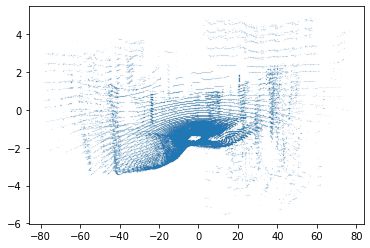

In [12]:
plt.scatter(pts[:,1],pts[:,2], s=0.001)

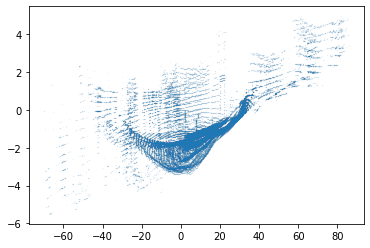

In [13]:
plt.scatter(pts[:,0],pts[:,2], s=0.001)

In [10]:
mlab.points3d(np.zeros_like(pts[:,0]), pts[:,1], pts[:,2], intens, mode='point')
mlab.show()

In [11]:
mlab.points3d(pts[:,0], np.zeros_like(pts[:,1]), pts[:,2], intens, mode='point')
mlab.show()